In [15]:
# Также вытащить по ссылке обозначения 
#        
#         # Обозначения метеопараметров см. по адресу http://rp5.ru/archive.php?wmo_id=27612&lang=ru

# Нужные колонки:
#         T - температура воздуха, С
#         Po - атмосферное давление на уровне станции, мм.рт.ст.
#         U-  относительная влажность %
#         DD - направление ветра.
#         Ff - скорость ветра
#         N - общая облачность, строка
#         Td - температура точки росы, С
        
        
        

# В файле данные по погоде с 01.01.2006 по 28.02.2023

#         Как только разговор заходит про новый год, Маша говорит,
#         - "Никогда больше не буду праздновать в Москве.        Народу тьма, все забито:
#         кино, кафе, катки - никуда не попасть. Еще и мороз -30 С"
#         -"30??? Серьезно? такого никогда же не было?? Или Было?"
        
#         Проверим, сколько раз в период с 2006 по 2023 температура в Москве опускалась до -30 и ниже.
#         Сколько дней (часов) это длилось и на какие даты выпадало.


In [16]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import pi,isnan

# !pip install windrose openpyxl
# from windrose import WindroseAxes

Считываем информацию из заглавной части файла

In [201]:
file = open('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-posazhennikov/RP5/27612.01.01.2006.28.02.2023.1.0.0.ru.utf8.00000000.csv')
lines = file.readlines()
for i in lines:
    if i.startswith('#'):
        print(i)

# Метеостанция Москва (ВДНХ), Россия, WMO_ID=27612, выборка с 01.01.2006 по 28.02.2023, все дни

# Кодировка: UTF-8

# Информация предоставлена сайтом "Расписание Погоды", rp5.ru

# Пожалуйста, при использовании данных, любезно указывайте названный сайт.

# Обозначения метеопараметров см. по адресу http://rp5.ru/archive.php?wmo_id=27612&lang=ru

#



In [78]:
df = pd.read_csv('27612.01.01.2006.28.02.2023.1.0.0.ru.utf8.00000000.csv',  sep =';', skiprows = 6,index_col=False)

### Предобработка датасета: переименуем колонки, преобразуем даты, 

In [91]:
weather = df[['Местное время в Москве (ВДНХ)','T','Po','U','DD','Ff','N','Td']]\
    .rename(columns = {'Местное время в Москве (ВДНХ)':'date_time',
                       'T':'air_temperature',
                       'Po':'pressure',
                       'U':'rel_humidity',
                       'DD':'wind_direction',
                       'Ff':'wind_speed',
                       'N':'cloudness',
                       'Td':'dew_point_temp'})
weather['date_time'] = pd.to_datetime(weather.date_time, dayfirst=True)
weather = weather.sort_values('date_time', ascending = True).reset_index(drop=True)

In [92]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59486 entries, 0 to 59485
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_time        59486 non-null  datetime64[ns]
 1   air_temperature  59480 non-null  float64       
 2   pressure         59317 non-null  float64       
 3   rel_humidity     59445 non-null  float64       
 4   wind_direction   59436 non-null  object        
 5   wind_speed       59436 non-null  float64       
 6   cloudness        55763 non-null  object        
 7   dew_point_temp   59452 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 3.6+ MB


In [93]:
weather.head()

,date_time,air_temperature,pressure,rel_humidity,wind_direction,wind_speed,cloudness,dew_point_temp
0,2006-01-01 00:00:00,-5.3,755.4,93.0,"Ветер, дующий с юго-востока",2.0,100%.,-6.3
1,2006-01-01 03:00:00,-6.1,756.2,89.0,"Ветер, дующий с юго-востока",1.0,100%.,-7.6
2,2006-01-01 06:00:00,-6.1,756.7,79.0,"Ветер, дующий с юго-востока",2.0,100%.,-9.2
3,2006-01-01 09:00:00,-7.0,757.8,77.0,"Ветер, дующий с юго-востока",3.0,100%.,-10.3
4,2006-01-01 12:00:00,-7.0,758.9,82.0,"Ветер, дующий с юго-востока",2.0,100%.,-9.5


In [94]:
weather.wind_direction.unique()

array(['Ветер, дующий с юго-востока',
       'Ветер, дующий с востоко-юго-востока', 'Штиль, безветрие',
       'Ветер, дующий с востока', 'Ветер, дующий с севера',
       'Ветер, дующий с северо-северо-востока',
       'Ветер, дующий с западо-северо-запада',
       'Ветер, дующий с западо-юго-запада',
       'Ветер, дующий с северо-запада',
       'Ветер, дующий с северо-северо-запада', 'Ветер, дующий с запада',
       'Ветер, дующий с юго-запада', 'Ветер, дующий с северо-востока',
       'Ветер, дующий с востоко-северо-востока',
       'Ветер, дующий с юго-юго-запада',
       'Ветер, дующий с юго-юго-востока', nan, 'Ветер, дующий с юга',
       'Переменное направление'], dtype=object)

### Посмотрим на погоду в январе. Создадим колонки 'год' и 'месяц' отсортируемся по январям

In [95]:
weather['day_num'] = weather.date_time.dt.day
weather['year'] = weather.date_time.dt.year
weather['month'] = weather.date_time.dt.month_name()

In [96]:
jans = weather.loc[weather.month == 'January']

### Для построения графиков по годам, преобразуем данные. Возьмем минимальные температуры суток для каждого дня

In [97]:
min_day_temp = jans.groupby(['year','day_num'], as_index = False).agg({'air_temperature':'min'})

In [98]:
pivot_temp = min_day_temp.pivot("day_num", "year",  "air_temperature")

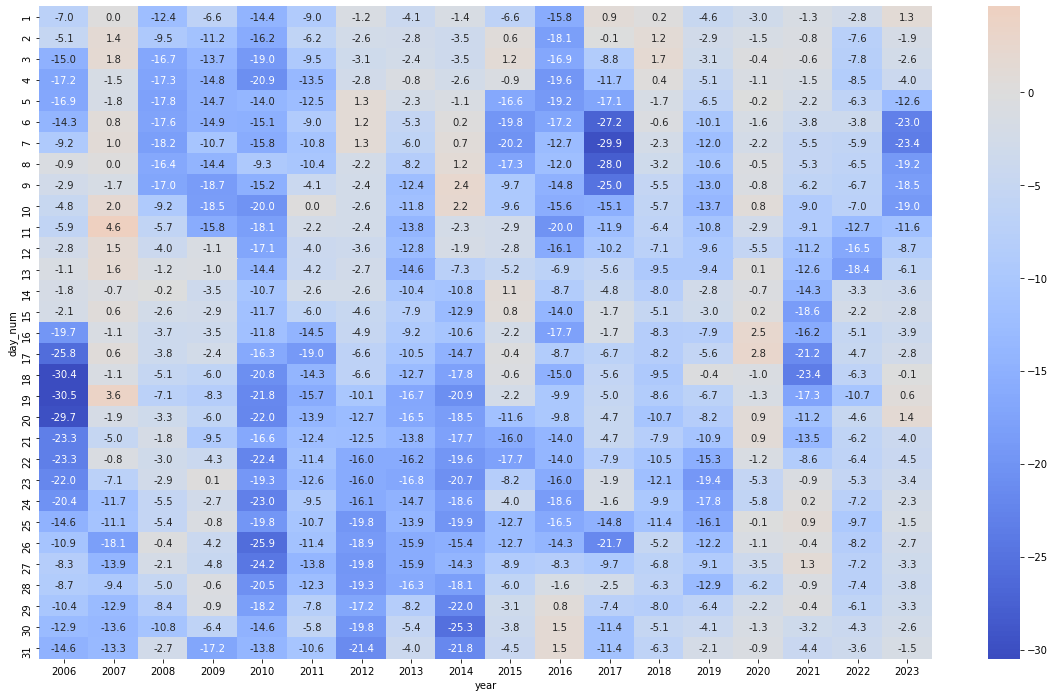

In [99]:
plt.figure(figsize = (20,12))
sns.heatmap(pivot_temp, annot = True, cmap = 'coolwarm', center = 0,fmt=".1f"  )

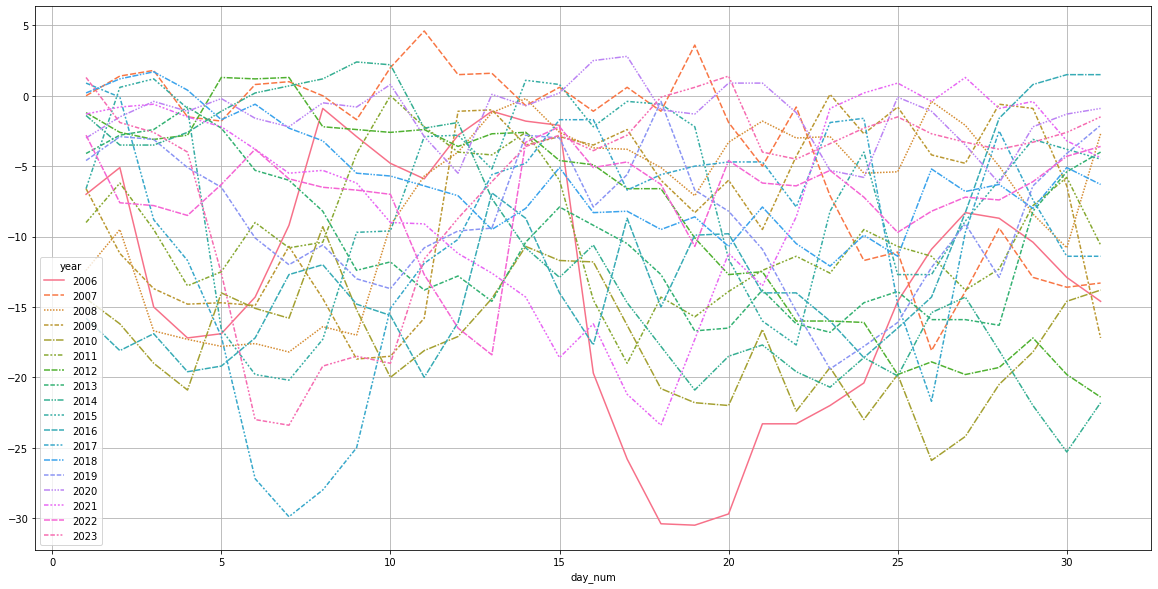

In [100]:
plt.figure(figsize = (20,10))
plt.grid()
sns.lineplot(data =pivot_temp)


### Ну и в цифрах

In [101]:
weather.loc[(weather.air_temperature <= -30)]

,date_time,air_temperature,pressure,rel_humidity,wind_direction,wind_speed,cloudness,dew_point_temp,day_num,year,month
139,2006-01-18 09:00:00,-30.4,758.2,80.0,"Ветер, дующий с северо-северо-востока",1.0,"10% или менее, но не 0",-32.7,18,2006,January
144,2006-01-19 00:00:00,-30.0,758.2,80.0,"Ветер, дующий с востока",2.0,Облаков нет.,-32.3,19,2006,January
145,2006-01-19 03:00:00,-30.2,758.6,80.0,"Ветер, дующий с востоко-северо-востока",1.0,Облаков нет.,-32.5,19,2006,January
146,2006-01-19 06:00:00,-30.5,758.5,81.0,"Ветер, дующий с востока",1.0,100%.,-32.7,19,2006,January
147,2006-01-19 09:00:00,-30.2,759.1,80.0,"Ветер, дующий с востоко-северо-востока",1.0,40%.,-32.5,19,2006,January


Попробуем посчитать продолжительность периодов. Сформируем колонку "time_shift" в которую поместим разницу между отметкой времени в текущей строек и следующей.Таким образом каждая строка будет иметь период своего действия. Отфильтруемся по температуре и получим в результате расчет периода с любой установленной температурой

In [185]:
temperature = -25

In [186]:
weather['time_shift'] = weather.date_time - weather.date_time.shift()
weather.query(f'air_temperature < {temperature}').time_shift.sum()

Timedelta('7 days 17:00:00')

Также посчитаем количество календарных дней в которые температура опускалась ниже указанной (хитрая статистика)

In [188]:
days_below = weather.loc[weather.air_temperature < temperature]['date_time'].dt.date.nunique()
days_below

16

## Роза ветров.
Для нее нужно определить углы в радианах по строке wind_direction и радиус который будет суммой скоростей по каждому направлению

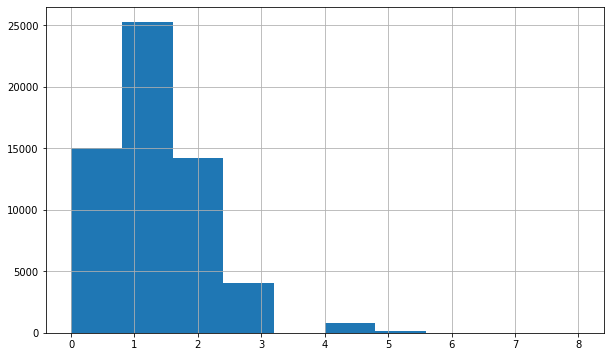

In [66]:
#Гистограмма скоростей ветров по г. Москва
weather['wind_speed'].hist(figsize=(10,6))

In [67]:

wind_replace = {'Ветер, дующий с севера': 2*pi,
                'Ветер, дующий с северо-северо-востока': pi/6,
                'Ветер, дующий с северо-востока': pi/4,
                'Ветер, дующий с востоко-северо-востока': pi/3,
                'Ветер, дующий с востока': pi/2,
                'Ветер, дующий с востоко-юго-востока': 2*pi/3,
                'Ветер, дующий с юго-востока': 3*pi/4,
                'Ветер, дующий с юго-юго-востока': 5*pi/6,
                'Ветер, дующий с юга': pi,
                'Ветер, дующий с юго-юго-запада': 7*pi/6,
                'Ветер, дующий с юго-запада': 5*pi/4,
                'Ветер, дующий с западо-юго-запада': 8*pi/6,
                'Ветер, дующий с запада': pi/2,
                'Ветер, дующий с западо-северо-запада':5*pi/3,
                'Ветер, дующий с северо-запада':7*pi/4,
                'Ветер, дующий с северо-северо-запада': 11*pi/6,
                'Штиль, безветрие': "nan",
                'Переменное направление': 'nan'}
             

In [68]:
weather['wind_direction_rad']  = weather.wind_direction.replace(wind_replace)

In [69]:
wind_rose = weather.query('wind_direction_rad != "nan"')\
                    .groupby('wind_direction_rad', as_index = False)\
                    .agg({'wind_speed':'sum'}).sort_values('wind_direction_rad')


In [70]:
wind_rose['wind_speed_perc'] = (wind_rose.wind_speed / wind_rose.wind_speed.max()).round(2)

In [71]:
wind_rose

,wind_direction_rad,wind_speed,wind_speed_perc
0,0.523599,3866.0,0.46
1,0.785398,2609.0,0.31
2,1.047198,1692.0,0.20
3,1.570796,8056.0,0.95
4,2.094395,1980.0,0.23
5,2.356194,4560.0,0.54
6,2.617994,7260.0,0.86
7,3.141593,4970.0,0.59
8,3.665191,2436.0,0.29
9,3.926991,4022.0,0.47


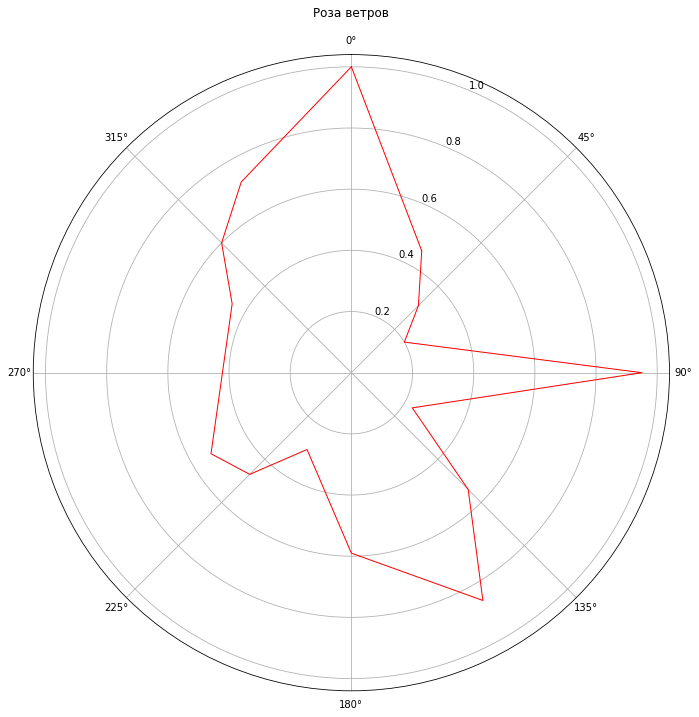

In [75]:
# Расчет и графика розы ветров

fig = plt.figure(figsize=(16,10)) # зададим явно размер полотна, чтобы графики не перекрывались


angles = np.array(wind_rose.wind_direction_rad)
r = np.array(wind_rose.wind_speed_perc) 

ax = fig.add_subplot(projection='polar')
ax.plot(angles, r, color='r', linewidth=1.)
# Так как 0 и 2*pi - это одна и та же точка, то значение в ней должно быть одно
# Однако, будет разрыв между последней точкой и нулевой.
# Чтобы его убрать, искусственно соединим эти точки.

# Замыкаем розу ветров (соединяем конец с началом)
ax.plot((angles[-1],angles[0]),(r[-1],r[0]), color='r', linewidth=1.)

# Изменяем направление обхода с "против часовой" на "по часовой"
ax.set_theta_direction(-1)
    
# Смещаем нулевую или полярную ось на 90 градусов против часовой стрелки, в положение "север"
ax.set_theta_offset(pi/2.0)

ax.set_title('Роза ветров', loc='center')

plt.tight_layout()


plt.show()   

In [ ]:

# В этой  программе мы инициализируем переменную total_duration_cold_temps.
# для хранения общей продолжительности времени, когда температура была ниже -30 градусов.
# Мы также инициализируем переменную current_start_time для хранения времени начала текущего периода.
# при температуре ниже -30 градусов. Мы перебираем строки фрейма данных, используя метод iterrows().
# Если температура ниже -30 градусов и у нас еще не началась новая менструация,
# мы устанавливаем текущее время начала на отметку времени текущей строки.
# Если температура не ниже -30 градусов и у нас начались месячные,
# вычисляем продолжительность периода и прибавляем ее к общей продолжительности.
# Если в конце кадра данных есть период, когда температура все еще ниже -30 градусов,
# мы рассчитываем продолжительность этого периода и добавляем его к общей продолжительности.
# Наконец, мы печатаем общую продолжительность в часах, используя метод total_seconds().
# чтобы преобразовать продолжительность в секунды, а затем разделить на 3600, чтобы преобразовать в



# Initialize a variable to store the total duration of time when the temperature was below -27 degrees
# объявляем переменную для хранения общего периода времени, когда темепература ниже уставки
total_duration_cold_temps = pd.Timedelta(0)

# Initialize a variable to store the start time of the current period when the temperature is below -27 degrees
# объявляем переменную для хранения начала конкретного периода когда температура ниже уставки
current_start_time = None

# Iterate over the rows of the dataframe
# цикл по всем строкам датафрейма
for i, row in minus_29.iterrows():
    if row['air_temperature'] < -29:

        # если темп. меньше уставки и новый период еще не начался, установим точку старта периода
        if current_start_time is None:
            current_start_time = row['date_time']
    else:
        # Если темпратура выше уставки и уже начался период, то считаем длительность периода и прибавляем к общему.
        # Потом перезапускаем точку старта
        if current_start_time is not None:
            duration_cold_temps = row['date_time'] - current_start_time
            total_duration_cold_temps += duration_cold_temps
            current_start_time = None

# If there is a period when the temperature is still below -27 degrees at the end of the dataframe,
# calculate the duration of that period and add it to the total duration
# Если есть период с температтурой ниже уставки в конце датафрейма
# считаем продолжительность и прибавляеем к общей
if current_start_time is not None:
    duration_cold_temps = minus_29['date_time'].max() - current_start_time
    total_duration_cold_temps += duration_cold_temps

# Print the total duration in hours, minutes, and seconds
print(f"The temperature was below -29 degrees for {total_duration_cold_temps.total_seconds() / 3600:.2f} hours.")